<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

## RANDOM FOREST

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import display_functions
import helper_functions
import model_functions

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

Nota: Estoy entrenando con todos los datos, no con los que he eliminado los outliers

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = helper_functions.load_feather_as_df(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
424,17711,0,0.321569,0.345098,0.321569,0.333333,0.068182,0.345098,36.710412,-3.674567,...,0.068182,0.035294,18.772741,0.070500,0.035294,2.235294,0.338397,1.073167,1.073167,0.999997
550,17603,0,0.188235,0.219608,0.258824,0.592593,0.272727,0.258824,23.169067,-0.666137,...,0.210525,-0.008850,18.791557,-0.005076,0.076923,-1.254902,0.215769,1.166660,0.848482,0.727270
44,6668,1,0.580392,0.501961,0.376471,0.102564,0.351351,0.580392,54.636696,2.728645,...,-0.111111,0.024000,18.780804,0.071130,-0.072464,4.784314,0.509575,0.864863,1.333330,1.541663
64,17812,1,0.305882,0.321569,0.298039,0.277778,0.073171,0.321569,34.346914,-2.903323,...,0.047619,0.031447,18.775847,0.062915,0.025000,1.960784,0.316535,1.051279,1.078944,1.026312
254,28809,1,0.486275,0.494118,0.415686,0.183333,0.158730,0.494118,52.115952,-4.495860,...,0.013889,0.045643,18.760757,0.094142,0.008000,4.980392,0.486787,1.016127,1.188676,1.169809


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


### Hold-out externo

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(453, 26)
(114, 26)


### Estandarización

No se estandarizaron los datos (no se aplicó StandardScaler), dado que Random Forest (y todos los modelos basados en árboles, tales como DecisionTree, ExtraTrees, XGBoost, LightGBM, CatBoost) no requieren escalado porque las divisiones en cada nodo se basan en umbrales sobre características individuales. Además, los árboles son invariantes a transformaciones escalares (media, desviación, etc.), l oque significa que el escalado no mejora el rendimiento, y por el contrario puede introducir inconsistencias si no se aplicó al ajustar el modelo.

### Construcción del modelo

Con parámetros fijos iniciales

In [10]:
rfc = sklearn.ensemble.RandomForestClassifier(
    class_weight="balanced", # ajusta automáticamente según la frecuencia de cada clase. Para evitar desbalanceo entre clases.
    random_state=42,
    n_jobs=-1 # usa todos los cores, en este modelo  no da error en MacOs
    # max_samples, para datasets grandes, aquí no tiene sentido.
)

Hiperparámetros

In [11]:
param_grid = {
    "n_estimators": [100, 200, 500, 1000], # número de árboles, 100 por defecto. 200–500 para índices espectrales
    "criterion": ["gini", "entropy","log_loss"], # métrica para medir la calidad de una partición: "gini", más rápida; "entropy" o "log_loss", ganancia de información. 
    "min_samples_split": [2, 10], # número mínimo de muestras para dividir un nodo
    "max_features":["sqrt", "log2"]  # número de variables consideradas en cada split. Por defecto “sqrt”, “log2”. Importante si se trabaja con espacios de color e índices redundantes.
}

Entrenamiento: GridSearchCV -> selección de hiperparámetros

StratifiedKFold -> hold-out interno

StratifiedKFold vs KFold


La validación cruzada mediante _KFold_ divide el conjunto de datos en  particiones de manera estrictamente aleatoria o secuencial sin considerar la distribución de la variable objetivo, lo cual puede derivar en subconjuntos que no reflejen la realidad de la población, particularmente en escenarios de clases desbalanceadas donde la clase minoritaria podría quedar excluida de ciertos pliegues. En contraste, _StratifiedKFold_ mitiga este sesgo al implementar un muestreo estratificado que preserva la proporción relativa de cada clase en todos los subconjuntos generados, garantizando así la representatividad estadística del dataset original en cada iteración; esta característica convierte a la variante estratificada en la aproximación metodológica superior para problemas de clasificación, pues asegura la estabilidad y fiabilidad de las métricas de evaluación independientemente del desequilibrio de las clases.

In [12]:
cv_rfc = GridSearchCV(
    rfc,
    param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), # n_splits=10, porque el dataset es muy pequeño
    scoring="f1_macro", # Cuando te importa detectar bien todas las clases (recall + precisión)
            #"balanced_accuracy", 
            # "accuracy" -> NO recomendable con clases desbalanceadas,
            # precision, recall, solo para clasificacion binaria
    return_train_score=True
)

Entrenamiento

In [13]:
cv_rfc.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 10], 'n_estimators': [100, 200, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


Resultados de la búsqueda de parámetros

In [14]:
results = pd.DataFrame(cv_rfc.cv_results_)
print(results[["params","mean_test_score","std_test_score"]]) # Mostramos solo las columnas útiles

                                               params  mean_test_score  \
0   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.747129   
1   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.761023   
2   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.755908   
3   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.749984   
4   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.747768   
5   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.737822   
6   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.751431   
7   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.743251   
8   {'criterion': 'gini', 'max_features': 'log2', ...         0.763719   
9   {'criterion': 'gini', 'max_features': 'log2', ...         0.762563   
10  {'criterion': 'gini', 'max_features': 'log2', ...         0.751924   
11  {'criterion': 'gini', 'max_features': 'log2', ...         0.750676   
12  {'criterion': 'gini', 'max_feature

### Métricas

Mejor modelo

In [15]:
rf_best_model = cv_rfc.best_estimator_
print("Mejor hiperparámetros: ", cv_rfc.best_params_)

Mejor hiperparámetros:  {'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


Predicción

In [16]:
y_pred = rf_best_model.predict(X_test)

Evaluación del mejor modelo con el conjunto test

In [17]:
mse, rmse, r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.15789473684210525
RMSE:  0.39735970711951313
R²:    0.5692695214105794
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        73
           1       0.74      0.74      0.74        34
           2       0.57      0.57      0.57         7

    accuracy                           0.84       114
   macro avg       0.74      0.74      0.74       114
weighted avg       0.84      0.84      0.84       114

[[67  6  0]
 [ 6 25  3]
 [ 0  3  4]]


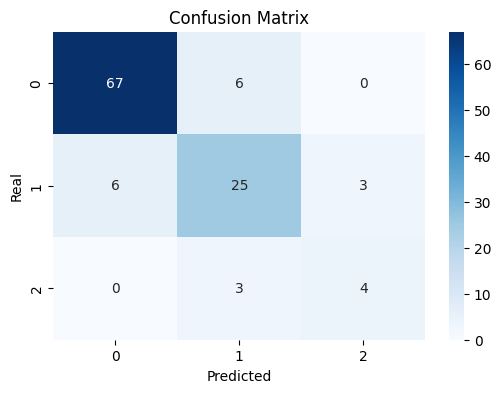

In [18]:
display_functions.plot_confusion_matrix(conf_matrix)

### Ploteamos la curva ROC

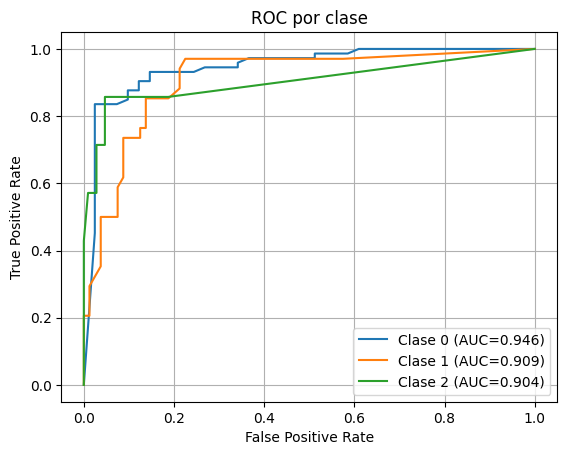

In [19]:
display_functions.plot_roc_curve(rf_best_model,X_test, y_test)

## Save Random forest best model

In [20]:
rf_best_model_path = os.path.join(project_models, "rf_best_model.pkl")

model_functions.save_model(rf_best_model, rf_best_model_path)